<a href="https://colab.research.google.com/github/ABD-01/MNIST/blob/main/Triplet%20Loss/TRIPLET_LOSS_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from itertools import combinations 
from collections import OrderedDict
from tqdm import tqdm

import tensorflow as tf
 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
import torchvision
import torchvision.transforms as transforms

In [ ]:
# plt.rcParams['figure.figsize'] = (5, 5)

# Utils

In [ ]:
def triplet_loss(anchor, positive, negative, margin=0.2):
    pos_dist = (anchor - positive).pow(2).sum(-1) #.pow(.5)
    neg_dist = (anchor - negative).pow(2).sum(-1) #.pow(.5)
    loss = F.relu(pos_dist - neg_dist + margin)
    return loss.mean()
 
# ref: https://github.com/adambielski/siamese-triplet/blob/master/losses.py#L24

In [ ]:
def tf_triplet_loss(anchor, positive, negative, margin=0.2):  
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    loss = tf.maximum(pos_dist - neg_dist + margin, 0)
    return tf.reduce_mean(loss)
 
# ref : https://stackoverflow.com/questions/38260113/implementing-contrastive-loss-and-triplet-loss-in-tensorflow/38270293#38270293

In [ ]:
torch_triplet_loss = nn.TripletMarginLoss(margin=0.2)

In [ ]:
def get_all_triplets(embeddings:list, targets:list) -> list:
    '''
    Parameters
    ----------
    embeddings : list of torch.tensor
    targets    : list of ints

    Returns
    -------
    triplets   : list of tuple
    '''

    # eg : no(targets) = 3
    # eg : no(embeds) = 10

    assert len(embeddings) == len(targets) , "Embeddings and Targets must have same lenght"

    triplets = []
    for i, anchor in enumerate(embeddings):

        positive_pairs = list(combinations(anchor,2))  # this will give of distinct pairs of elements 
                                                                 # no(pos_pairs) = no(targets)P2 / 2!  # eg : 45
        
        temp = embeddings.pop(i)  # embeddings list except the anchor
        for negative_embeddings in torch.cat(embeddings,dim=0):   # loops runs for no(targets)-1 * no(embeds) times  # eg : (3-1)*10=20 
            
            triple = [(positive_pair[0], positive_pair[1], negative_embeddings) for positive_pair in positive_pairs]  # no(triple) = n(pos_pair) # eg: 45
            
            triplets.extend(triple)   # no. of triplets added = no(pos_pairs)*(no(targets) - 1)*(no(embeds))  # eg: 45*2*10=900

        embeddings.insert(i, temp)

    return triplets  # no(triplets) = no(added_triples) * no(embeds) # eg: 900*3 = 2700

# ref : A lot can't even even mention here

In [ ]:
def get_all_tensor_triplets(embeddings:list, targets:list) -> torch.Tensor:
    '''
    Parameters
    ----------
    embeddings : list of torch.tensor each of shape torch.Size([?, 128])
    targets    : list of ints

    Returns
    -------
    triplets   : torch.tensor of shape torch.Size([?, no(triplets), 3])
    '''

    # eg : no(targets) = 3
    # eg : no(embeds) = 10

    assert len(embeddings) == len(targets) , "Embeddings and Targets must have same lenght"

    triplets = []
    for i, anchor in enumerate(embeddings):

        positive_pairs = list(combinations(anchor,2))  # this will give of distinct pairs of elements 
                                                                 # no(pos_pairs) = no(targets)P2 / 2!  # eg : 45
        
        temp = embeddings.pop(i)  # embeddings list except the anchor
        for negative_embeddings in torch.cat(embeddings,dim=0):   # loops runs for no(targets)-1 * no(embeds) times  # eg : (3-1)*10=20 
            
            triple = [torch.stack([positive_pair[0], positive_pair[1], negative_embeddings], dim=0) for positive_pair in positive_pairs]  # no(triple) = n(pos_pair) # eg: 45
            
            triplets.extend(triple)   # no. of triplets added = no(pos_pairs)*(no(targets) - 1)*(no(embeds))  # eg: 45*2*10=900

        embeddings.insert(i, temp)

    return torch.stack(triplets, dim=0)  # no(triplets) = no(added_triples) * no(embeds) # eg: 900*3 = 2700

# ref : A lot can't even even mention here

In [ ]:
def get_random_triplets(embeddings:list,  targets:list) -> torch.Tensor:
    '''
    For each image in data (Anchor), randomly sample a Positive image from its class.  
    Then from each of the other classes sample one image (randomly) as the Negative. Hence, for every Anchor
    you will have 1 randomly selected positive from it's class and randomly selected Negative from each of the n-1 classes 
    where n is total number of classes.  For every Anchor image you would have n-1 triplets.
    So if you're having 3 classes of 10 images each then you would have 60 triplets. 
    '''


    assert len(embeddings) == len(targets) , "Embeddings and Targets must have same lenght"

    triplets = []
    for i, embedding in enumerate(embeddings):
        temp = embeddings.pop(i)

        for anchor in embedding:
            positive = random.choice(embedding)

            for negatives in embeddings:
                negative = random.choice(negatives)

                triplets.append(torch.stack([anchor, positive, negative], dim=0))

        embeddings.insert(i, temp)

    return torch.stack(triplets, dim=0)  


In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
 
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(3):
        plt.scatter(embeddings[i].detach().numpy()[:,0],embeddings[i].detach().numpy()[:,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(targets)

# ref: https://github.com/adambielski/siamese-triplet/blob/master/Experiments_MNIST.ipynb

In [ ]:
MNIST_train = torchvision.datasets.MNIST(
    root = '/content/drive/MyDrive/Colab Notebooks/',
    download = True,
    train = True,
    transform = transforms.ToTensor()
)

In [ ]:
MNIST_train.data.shape

torch.Size([60000, 28, 28])

4

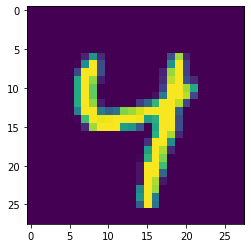

In [ ]:
i =5734
plt.imshow(MNIST_train[i][0].squeeze())
MNIST_train[i][1]

# Reorganizing Data

In [ ]:
train_dict = {i : MNIST_train.data[MNIST_train.targets == i].unsqueeze(1) / 255 for i in range(10)}
print(*[f'{imgs.shape[0]} images of Label {label} of shape {imgs.shape[1:]}' for label, imgs in train_dict.items()], sep='\n')
# for i in range(10):
#     train_dict[i] = MNIST_train.data[MNIST.targets == i]

5923 images of Label 0 of shape torch.Size([1, 28, 28])
6742 images of Label 1 of shape torch.Size([1, 28, 28])
5958 images of Label 2 of shape torch.Size([1, 28, 28])
6131 images of Label 3 of shape torch.Size([1, 28, 28])
5842 images of Label 4 of shape torch.Size([1, 28, 28])
5421 images of Label 5 of shape torch.Size([1, 28, 28])
5918 images of Label 6 of shape torch.Size([1, 28, 28])
6265 images of Label 7 of shape torch.Size([1, 28, 28])
5851 images of Label 8 of shape torch.Size([1, 28, 28])
5949 images of Label 9 of shape torch.Size([1, 28, 28])


In [ ]:
label = 7
rand_imgs = train_dict[label][random.sample(range(1, 5000), 100)]
grid = torchvision.utils.make_grid(rand_imgs, nrow=10, pad_value=20)
# ref: https://pytorch.org/vision/stable/utils.html#torchvision-utils

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


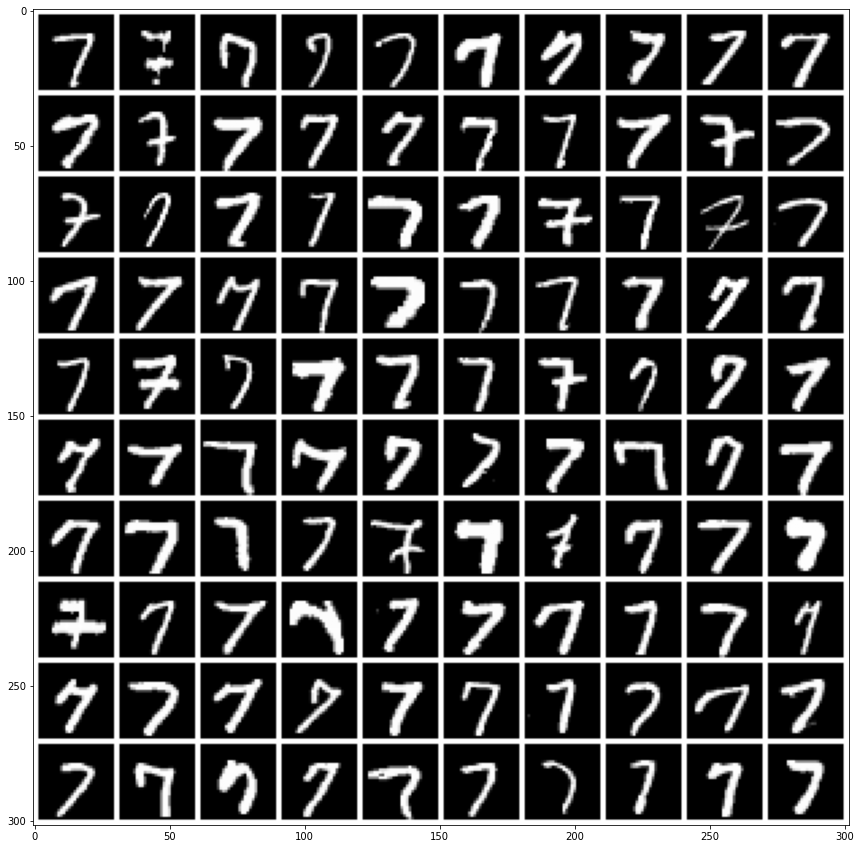

In [ ]:
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))

Image Processing 

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Normalize(mean=0.1307, std=0.3081),
    transforms.Lambda(lambda image: torch.cat((image,image,image), dim=-3)),
])
# ref: https://pytorch.org/hub/pytorch_vision_resnet/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


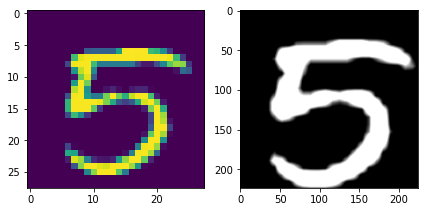

In [ ]:
timg = train_dict[5][63]  # shape = (1,28,28)
ptimg = preprocess(timg)  # shape = (3,224,224)
_, axarr = plt.subplots(1,2, figsize = (7,7)) 

axarr[0].imshow(timg.squeeze())

axarr[1].imshow(torch.movedim(ptimg, -3, -1))
#ref : https://pytorch.org/docs/stable/generated/torch.movedim.html

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


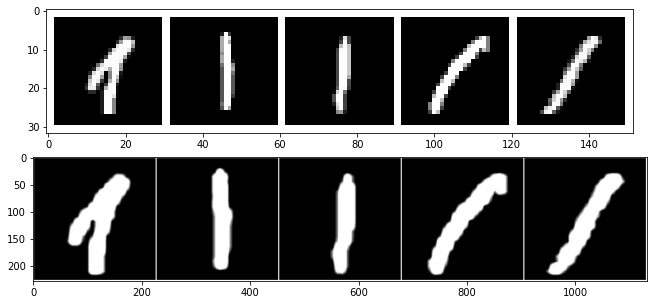

In [ ]:
rand_imgs = train_dict[1][random.sample(range(1, 5000), 5)]  # shape = (5,1,28,28)
grid = torchvision.utils.make_grid(rand_imgs, nrow=5, pad_value=20)

prand_imgs = preprocess(rand_imgs)  # shape = (5,3,224,224)
pgrid = torchvision.utils.make_grid(prand_imgs, nrow=5, pad_value=20)

fig , axarr = plt.subplots(2,1, figsize = (15,5)) 

axarr[0].imshow(np.transpose(grid, (1,2,0)))
axarr[1].imshow(np.transpose(pgrid, (1,2,0)))

In [ ]:
IMAGES = {0:train_dict[0][95], 1:train_dict[1][1], 2:train_dict[2][2], 3:train_dict[3][0]}
for i in [4,6,7,8]:
    IMAGES[i] = train_dict[i][1]
IMAGES[5] = train_dict[5][63]  
IMAGES[9] = train_dict[9][5]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


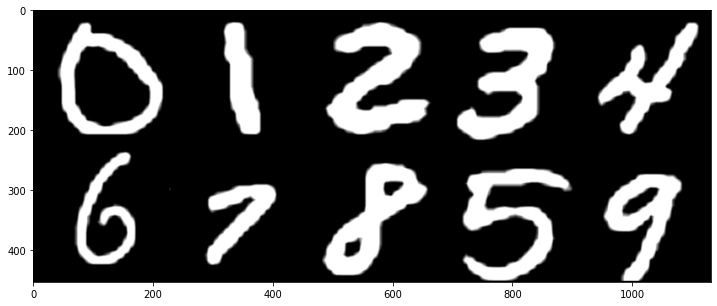

In [ ]:
GRID = torchvision.utils.make_grid(preprocess(torch.stack([*IMAGES.values()])), nrow=5)
plt.figure(figsize=(15,5))
plt.imshow(np.transpose(GRID, (1,2,0)))

# Creating Model

In [ ]:
# Self defined CNN Model


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.preprocess = transforms.Compose([
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                            transforms.Normalize(mean=0.1307, std=0.3081),
                            transforms.Lambda(lambda image: torch.cat((image,image,image), dim=-3)),
                        ])
        # ref: https://pytorch.org/hub/pytorch_vision_resnet/

        self.convnet1 = nn.Sequential(OrderedDict([
                            ('conv1', nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2)),
                            ('conv2', nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)),
                            ('relu', nn.ReLU()),
                            ('pool', nn.MaxPool2d(kernel_size=3, stride=2))
        ]))
        # ref : https://discuss.pytorch.org/t/is-it-possible-to-specify-a-name-for-each-layer-when-creating-the-model/33637/2
        self.convnet2 = nn.Sequential(
                            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
                            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.convnet3 = nn.Sequential(
                            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2),
                            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.FCs      = nn.Sequential(
                            nn.Linear(in_features=4096, out_features=2048), nn.ReLU(),
                            nn.Linear(in_features=2048, out_features=512), nn.ReLU(),
                            nn.Linear(in_features=512, out_features=128), nn.ReLU()
        )
        self.out      = nn.Linear(in_features=128, out_features=2)


    def forward(self, x):
        x = self.preprocess(x)
        x = self.convnet1(x)
        x = self.convnet2(x)
        x = self.convnet3(x)
        x = x.reshape(-1, 4*4*256)
        x = self.FCs(x)
        enc = self.out(x)
        return x

        

In [ ]:
'''
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.preprocess = transforms.Compose([
                            transforms.Resize(256),
                            transforms.CenterCrop(224),
                            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                            transforms.Normalize(mean=0.1307, std=0.3081),
                            transforms.Lambda(lambda image: torch.cat((image,image,image), dim=-3)),
                        ])
        # ref: https://pytorch.org/hub/pytorch_vision_resnet/

        self.resnet18 = torchvision.models.resnet18(pretrained=False)
        self.out = nn.Linear(in_features=1000, out_features=128)

    def forward(self, images):
        images = self.preprocess(images)
        images = self.resnet18(images)
        encodings = self.out(images)

        return encodings
'''


'\nclass Model(nn.Module):\n    def __init__(self):\n        super(Model, self).__init__()\n        self.preprocess = transforms.Compose([\n                            transforms.Resize(256),\n                            transforms.CenterCrop(224),\n                            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),\n                            transforms.Normalize(mean=0.1307, std=0.3081),\n                            transforms.Lambda(lambda image: torch.cat((image,image,image), dim=-3)),\n                        ])\n        # ref: https://pytorch.org/hub/pytorch_vision_resnet/\n\n        self.resnet18 = torchvision.models.resnet18(pretrained=False)\n        self.out = nn.Linear(in_features=1000, out_features=128)\n\n    def forward(self, images):\n        images = self.preprocess(images)\n        images = self.resnet18(images)\n        encodings = self.out(images)\n\n        return encodings\n'

# Visualizing Model

In [ ]:
model = Model()
model

Model(
  (convnet1): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (FCs): Sequential(
    (0): Linear(in_features=4096, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=128, 

In [ ]:
!pip install torchviz

     |████████████████████████████████| 51kB 6.3MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3522 sha256=1ef78d6b62e5148c538907df94698c6016499c2fe50c00b25ea91b75c8475693
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


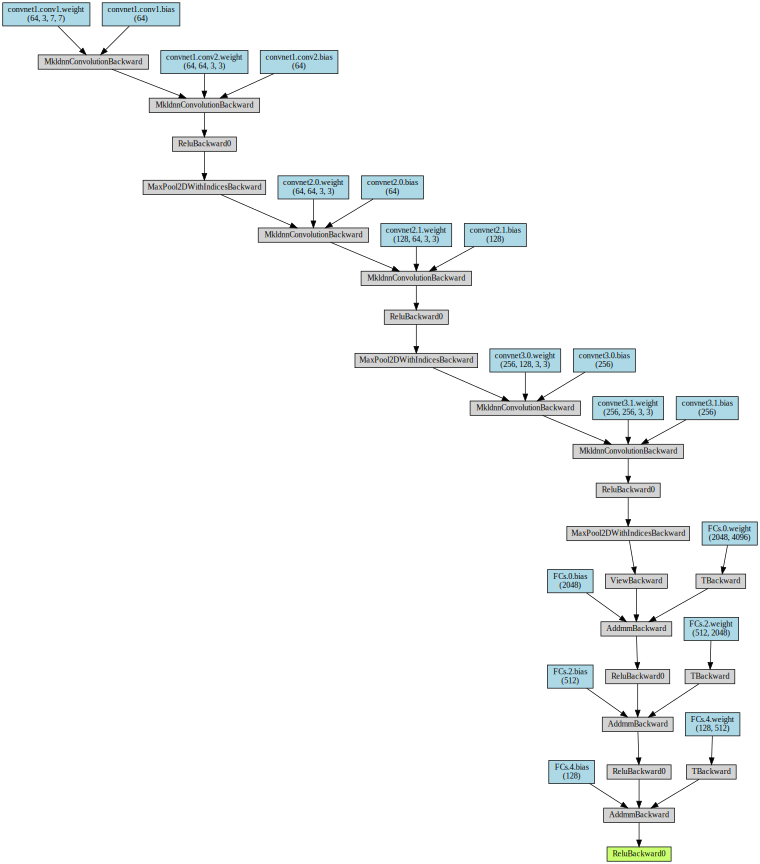

In [ ]:
from torchviz import make_dot

x = torch.randn(10,1,28,28)

make_dot(model(x), params=dict(model.named_parameters()))   

# ref : https://github.com/szagoruyko/pytorchviz/blob/master/examples.ipynb

In [ ]:
!pip install git+https://github.com/waleedka/hiddenlayer.git

  Cloning https://github.com/waleedka/hiddenlayer.git to /tmp/pip-req-build-a5zjcbpp
  Running command git clone -q https://github.com/waleedka/hiddenlayer.git /tmp/pip-req-build-a5zjcbpp
  Created wheel for hiddenlayer: filename=hiddenlayer-0.2-cp36-none-any.whl size=19771 sha256=81b5a693e7f626d0fb948475971c89d889085c0d747828cff6ae91bce0bab968
  Stored in directory: /tmp/pip-ephem-wheel-cache-7gvydnpr/wheels/49/bc/d1/938073704abdd049b3e4cdc6811c8f468d69fb5eecc6e01748
Successfully built hiddenlayer


/usr/local/lib/python3.6/dist-packages/torch/onnx/symbolic_helper.py:267: UserWarning: You are trying to export the model with onnx:Upsample for ONNX opset version 9. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transformation_mode and nearest_mode).
We recommend using opset 11 and above for models using this operator. 
  "" + str(_export_onnx_opset_version) + ". "


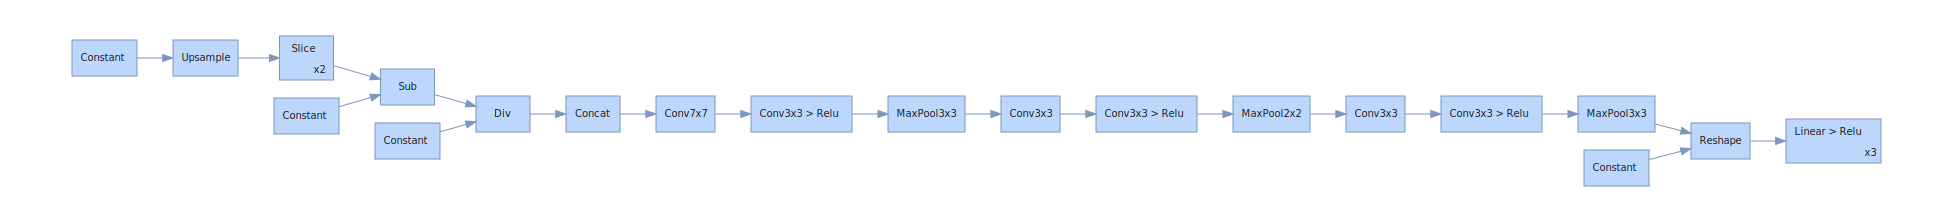

In [ ]:
import hiddenlayer as hl

# Build HiddenLayer graph
hl_graph = hl.build_graph(model, torch.zeros([1, 1, 28, 28]))

# Use a different color theme
hl_graph.theme = hl.graph.THEMES["blue"].copy()  # Two options: basic and blue
hl_graph

#ref : https://github.com/waleedka/hiddenlayer/blob/master/demos/pytorch_graph.ipynb

In [ ]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
 
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    # out = model.out
    plt.figure(figsize=(10,10))
    for i in range(10):
        # emb = out(embeddings[i])
        # plt.scatter(emb.detach().numpy()[:,0],emb.detach().numpy()[:,1], alpha=0.5, color=colors[i])
        plt.scatter(embeddings[i].detach().numpy()[:,0],embeddings[i].detach().numpy()[:,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(targets)

# ref: https://github.com/adambielski/siamese-triplet/blob/master/Experiments_MNIST.ipynb

# Running the Model

In [ ]:
def weights_init(layer):
    classname = layer.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal_(layer.weight.data, nonlinearity='relu')  # He-initialization
        # ref : https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_
        
# Reference : https://discuss.pytorch.org/t/weight-initilzation/157

In [ ]:
model = Model()
model.apply(weights_init)

learning_rate = 0.001
lossfn = triplet_loss
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)


In [ ]:
zeros_images = train_dict[0][:100]
ones_images  = train_dict[1][:100]
twos_images  = train_dict[2][:100]

images = torch.stack([zeros_images, ones_images, twos_images], dim=1)
images.shape  # images[:,0,...].shape = torch.Size([100, 1, 28, 28])

torch.Size([100, 3, 1, 28, 28])

In [ ]:
loader = torch.utils.data.DataLoader(images, batch_size=10)
len(loader)
# sample = next(iter(loader))
# sample.shape = torch.Size([10, 3, 1, 28, 28])

10

In [ ]:
enc0 = []
enc1 = []
enc2 = []
for batch in tqdm(loader):
    enc0.append(model(batch[:,0,...]))
    enc1.append(model(batch[:,1,...]))
    enc2.append(model(batch[:,2,...]))
enc0 = torch.cat(enc0)
enc1 = torch.cat(enc1)
enc2 = torch.cat(enc2)
enc0.shape, enc1.shape, enc2.shape

100%|██████████| 10/10 [00:10<00:00,  1.04s/it]


(torch.Size([100, 128]), torch.Size([100, 128]), torch.Size([100, 128]))

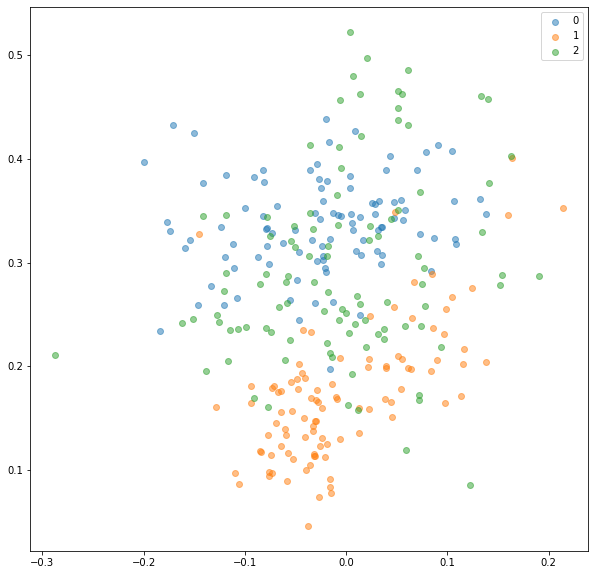

In [ ]:
plot_embeddings(embeddings=[enc0, enc1, enc2], targets=[0,1,2])

In [ ]:
# zeros_images = train_dict[0][:100]
# ones_images  = train_dict[1][:100]
# twos_images  = train_dict[2][:100]

# triplets = get_random_triplets([zeros_images, ones_images, twos_images], [0, 1, 2])

# cost = []

# epochs = 5
# for epoch in range(epochs):
#     anchor    = model(triplets[:,0,...])
#     positive  = model(triplets[:,1,...])
#     negative  = model(triplets[:,2,...])

#     optimizer.zero_grad()
#     loss = lossfn(anchor, positive, negative, margin=1)
#     cost.append(loss)

    
#     loss.backward(retain_graph=True)
#     optimizer.step()

#     print(f'Epoch:[{epoch+1}/{epochs}] , Cost : {loss.item()}')


In [ ]:
cost = []

epochs = 5
for epoch in range(epochs):
    for batch in loader:
        zeros_encodings = model(batch[:,0,...])
        ones_encodings  = model(batch[:,1,...])
        twos_encodings  = model(batch[:,2,...])

        triplets = get_random_triplets([zeros_encodings, ones_encodings, twos_encodings], [0, 1, 2])

        anchor   = triplets[:,0]
        positive = triplets[:,1]
        negative = triplets[:,2]

        optimizer.zero_grad()
        loss = lossfn(anchor, positive, negative, margin=1)
        cost.append(loss)

        
        loss.backward()
        optimizer.step()

        print(f'Epoch:[{epoch+1}/{epochs}] , Cost : {loss.item()}')


Epoch:[1/5] , Cost : 0.48034152388572693
Epoch:[1/5] , Cost : 17.307544708251953
Epoch:[1/5] , Cost : 0.20020408928394318
Epoch:[1/5] , Cost : 0.6049372553825378
Epoch:[1/5] , Cost : 0.15281057357788086
Epoch:[1/5] , Cost : 0.1942419707775116
Epoch:[1/5] , Cost : 0.8722952604293823
Epoch:[1/5] , Cost : 0.4189496338367462
Epoch:[1/5] , Cost : 0.5494107007980347
Epoch:[1/5] , Cost : 0.3156578242778778
Epoch:[2/5] , Cost : 0.28226298093795776
Epoch:[2/5] , Cost : 0.7596415877342224
Epoch:[2/5] , Cost : 0.8646437525749207
Epoch:[2/5] , Cost : 0.46591058373451233
Epoch:[2/5] , Cost : 0.0
Epoch:[2/5] , Cost : 0.5275298953056335
Epoch:[2/5] , Cost : 0.12644460797309875
Epoch:[2/5] , Cost : 0.4144960343837738
Epoch:[2/5] , Cost : 0.13242125511169434
Epoch:[2/5] , Cost : 0.11156858503818512
Epoch:[3/5] , Cost : 0.3399403393268585
Epoch:[3/5] , Cost : 0.24400633573532104
Epoch:[3/5] , Cost : 0.15697017312049866
Epoch:[3/5] , Cost : 0.08932559937238693
Epoch:[3/5] , Cost : 0.05054459720849991
Epo

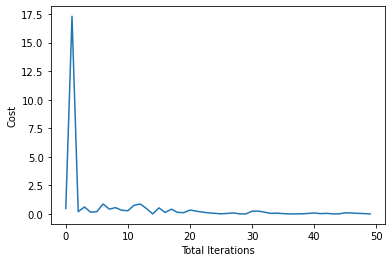

In [ ]:
plt.xlabel('Total Iterations')
plt.ylabel('Cost')
plt.plot(np.arange(epochs*len(loader)), cost)
plt.show()

100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


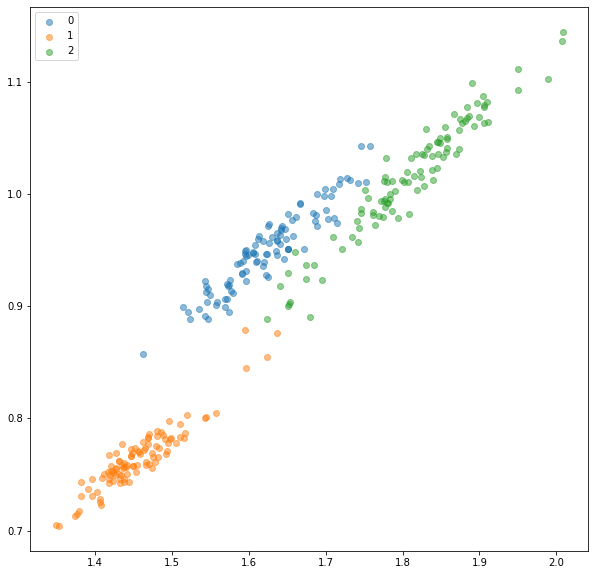

In [ ]:
enc0 = []
enc1 = []
enc2 = []
for batch in tqdm(loader):
    enc0.append(model(batch[:,0,...]))
    enc1.append(model(batch[:,1,...]))
    enc2.append(model(batch[:,2,...]))
enc0 = torch.cat(enc0)
enc1 = torch.cat(enc1)
enc2 = torch.cat(enc2)
plot_embeddings([enc0, enc1, enc2], [0,1,2])

In [ ]:
enc0.shape , enc1.shape, enc2[0].shape

(torch.Size([100, 128]), torch.Size([100, 128]), torch.Size([128]))

In [ ]:
(enc0 - enc1).pow(2).sum(-1)

tensor([ 9.2396, 23.5127,  8.5867, 13.7780, 11.1262, 20.2742, 13.6006, 13.3683,
         9.3032, 14.0640, 13.9151, 14.5957, 10.7086, 17.7924, 23.4412, 18.8906,
         9.6972, 19.1447, 10.9605, 11.9181, 15.5253, 18.1852, 20.3723, 17.8784,
         9.8210, 21.0309, 10.4136,  7.2366, 10.9687, 21.9534, 14.2016, 12.4749,
        16.7444, 17.0485, 16.7282, 10.4014, 13.1464, 17.6342, 13.0385, 10.8810,
        23.1875, 15.8244, 11.4262,  6.5965,  7.6375, 17.0752, 22.4500, 19.9849,
        10.2977, 10.1237,  7.5304, 19.7385, 22.6744,  9.2951,  7.2510,  9.2579,
         8.2472, 18.8627, 10.2933, 14.6191,  6.8366,  9.5630,  7.9020, 15.9339,
         3.3210,  4.2399,  8.6607,  7.7433, 10.1124,  5.6612,  6.0946,  4.7243,
        11.4431,  7.6705,  9.6198, 14.6567,  8.5807,  6.2726,  9.4517, 17.8041,
         5.4727, 17.3623,  4.6085, 18.2720,  8.1694, 10.7833,  8.1893,  6.7217,
         7.3085,  1.1852, 11.9318,  4.6302,  9.3698,  4.5732,  4.4222, 15.2251,
         9.6534,  6.3840,  4.0371,  5.92

In [ ]:
(enc0 - enc2).pow(2).sum(-1)

tensor([ 9.4574, 19.2025,  5.4230,  9.0396,  9.0659, 13.7459,  9.4704,  6.7173,
         8.9868, 14.7874, 11.3690, 14.4522,  7.1286, 12.1067,  9.4959, 15.4699,
         6.5397,  6.3295,  9.3842, 11.5632, 13.1484, 12.3659, 16.4766,  9.9248,
         7.1062,  4.3393,  5.5317,  9.1921, 11.3314, 12.0930,  6.8995, 13.3486,
        16.9077,  9.2423, 10.5985, 13.7310, 13.2433, 13.8188, 11.8245, 15.1566,
        16.2026,  9.9691,  7.5312, 11.8334,  8.0836, 22.8118, 16.5977, 12.3989,
         8.0188,  4.4405,  8.4128, 10.0885, 11.0354,  8.8568,  7.6138,  7.6411,
        11.6756,  8.3662,  6.5684, 12.1777,  2.9286,  9.7683, 13.0811,  9.0239,
         3.4559,  6.4316, 11.0705, 14.7190, 12.9443,  6.9777, 10.2631,  9.6035,
        11.6363, 13.0357,  5.9978, 12.1896, 10.8102, 11.0873,  6.2189, 14.2003,
         4.1951, 11.8317, 11.4010,  8.8131,  5.3703,  9.1820,  1.0638,  1.3664,
        11.2220,  4.7462,  4.6964,  5.7729,  3.6890,  3.6109,  5.9578, 12.3615,
         4.6254,  6.9417,  4.0829,  6.57

In [ ]:
(enc1 - enc2).pow(2).sum(-1)

tensor([1.4522, 7.8424, 5.1745, 3.1037, 1.1081, 2.3443, 4.7863, 2.2301, 2.0183,
        1.5267, 3.1677, 4.7195, 2.8226, 3.8122, 7.3588, 1.1923, 3.6762, 4.5469,
        2.2599, 3.5136, 5.2256, 5.3960, 3.1311, 2.3006, 4.4632, 7.6733, 4.2578,
        2.5176, 5.3543, 5.1982, 4.0940, 1.4298, 3.8487, 5.5541, 2.3531, 4.3363,
        2.8128, 4.2208, 1.9965, 2.0097, 1.7674, 1.4547, 1.2076, 2.5489, 3.4816,
        1.6874, 3.6934, 4.1175, 3.3289, 3.9120, 3.1825, 6.9366, 6.4688, 5.8301,
        4.4228, 3.2058, 2.6521, 3.2191, 4.6336, 3.1047, 3.9462, 1.9649, 1.1794,
        5.3742, 1.6897, 5.7432, 1.3880, 3.4509, 3.1201, 1.3755, 2.7325, 1.9133,
        6.7470, 2.5117, 4.9502, 4.6507, 3.3060, 2.2760, 0.8014, 1.8473, 5.6055,
        3.4477, 3.2373, 4.5906, 2.6302, 4.2062, 5.5388, 4.0105, 4.5044, 3.6904,
        6.4224, 4.2884, 4.9172, 3.2081, 2.8160, 3.5425, 4.1399, 0.9327, 3.0564,
        4.6420], grad_fn=<SumBackward1>)

In [27]:
IMAGES_ENC = {k:model(v.unsqueeze(0)) for k,v in IMAGES.items()}


In [ ]:
(0.36 + 0.97 + 1.17) / 3

0.8333333333333334

In [ ]:
train_dict[0].shape

torch.Size([5923, 1, 28, 28])

In [ ]:
zeros = model(train_dict[0][:100])

In [ ]:
(zeros - IMAGES_ENC[0]).shape

torch.Size([100, 128])

In [ ]:
zero_dist = (zeros - IMAGES_ENC[0]).pow(2).sum(-1)

In [ ]:
zero_dist.max() - zero_dist.mean()

tensor(3.9666, grad_fn=<SubBackward0>)

In [ ]:
(zero_dist < 12.6).sum()

tensor(100)

In [ ]:
(4 + 18.7 + 15.24)/3

12.646666666666667

In [ ]:
correct = {i:0 for i in range(10)}
for k , value in train_dict.items():
    vload = torch.utils.data.DataLoader(value, batch_size=50)
    for v in tqdm(vload, desc=f"Class : {k}", position=0, leave=True):
        correct[k] += ((model(v) - IMAGES_ENC[k]).pow(2).sum(-1) < 12.6).sum()

Class : 9: 100%|██████████| 119/119 [02:29<00:00,  1.25s/it]


In [ ]:
for i in range(10):
    c = correct[i].item()
    t = train_dict[i].shape[0]
    print(f'Class {i} : Correct = {c} out of {t} . Accuracy = {c / t * 100} %')

Class 0 : Correct = 5804 out of 5923 . Accuracy = 97.9908829984805 %
Class 1 : Correct = 6648 out of 6742 . Accuracy = 98.60575496885198 %
Class 2 : Correct = 5830 out of 5958 . Accuracy = 97.85162806310842 %
Class 3 : Correct = 5877 out of 6131 . Accuracy = 95.85711955635297 %
Class 4 : Correct = 5830 out of 5842 . Accuracy = 99.79459089352962 %
Class 5 : Correct = 5274 out of 5421 . Accuracy = 97.28832318760377 %
Class 6 : Correct = 5908 out of 5918 . Accuracy = 99.83102399459277 %
Class 7 : Correct = 5589 out of 6265 . Accuracy = 89.2098962490024 %
Class 8 : Correct = 5777 out of 5851 . Accuracy = 98.73525893009742 %
Class 9 : Correct = 5849 out of 5949 . Accuracy = 98.31904521768364 %


In [ ]:
# Saving the state_dict of Model
PATH = '/content/drive/MyDrive/Colab Notebooks/tripletLoss_on_MNIST'

In [ ]:
# torch.save(model.state_dict(), '/content/Triplet Loss/tripletLoss_on_MNIST')

In [ ]:
# Loadel the saved Model
# the_network = Network()
model.load_state_dict(torch.load(PATH))
model.eval()

Model(
  (convnet1): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (relu): ReLU()
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convnet3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (FCs): Sequential(
    (0): Linear(in_features=4096, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=128, 

In [28]:
imgs = [train_dict[i][:50] for i in range(10)]
imgs = torch.stack(imgs, dim=1)
imgs.shape  # images[:,0,...].shape = torch.Size([100, 1, 28, 28])

torch.Size([50, 10, 1, 28, 28])

In [29]:
loader = torch.utils.data.DataLoader(imgs, batch_size=10)
print(len(loader))
sample = next(iter(loader))
sample.shape #= torch.Size([10, 3, 1, 28, 28])

5


torch.Size([10, 10, 1, 28, 28])

In [41]:
for i in range(10):
    print('Class:',i)
    corr = 0
    for batch in loader:
        e = model(batch[:,i,...])
        dist = (e - IMAGES_ENC[i]).pow(2).sum(-1)
        print(dist.detach().numpy())
        corr += (dist < 12.6).sum()
    print(f'{corr} correct out of 50', end='\n\n')

Class: 0
[0.22764605 0.87449086 3.8630085  1.5246482  0.38611686 0.52835065
 2.7699053  1.0010312  2.6194046  1.8290253 ]
[1.3117498  0.07047038 1.0919499  2.2309055  0.3380883  1.4776926
 0.8308944  1.1621996  0.8414628  1.8580629 ]
[7.2725123e-01 5.6176805e-01 5.8013186e-02 1.6704376e+00 1.6704688e+00
 1.6254194e-01 3.6575801e+00 1.7645525e+00 4.8428483e+00 3.7312522e-03]
[4.3209643  0.29968652 0.17862886 3.3531637  0.47650144 1.2971154
 0.534302   0.51942855 0.8060161  0.46930203]
[0.49295884 0.2047084  1.7373748  3.0897725  1.7820816  0.4663869
 1.466769   5.372918   2.2793639  1.9740419 ]
50 correct out of 50

Class: 1
[7.6171017e+00 7.5033313e-12 2.4923499e+00 1.5919737e+00 5.4852715e+00
 1.7458073e+00 3.3257406e+00 7.4843574e+00 4.4460206e+00 2.2715251e+00]
[3.8004465 7.4051104 2.9221141 4.965489  1.5880914 0.6996284 6.3673005
 4.4399023 3.648812  2.9840317]
[1.7734386 1.0059928 2.1734362 1.7808584 2.4532006 0.936647  0.6674446
 6.7456183 8.68807   1.6435796]
[ 1.4552262  10.398

In [ ]:
# enc = {i:[] for i in range(10)}
for batch in tqdm(loader):
    for i in range(10):
        e = model(batch[:,i,...])
        enc[i].append(model.out(e))
    

100%|██████████| 5/5 [00:15<00:00,  3.10s/it]


In [ ]:
for i in range(10):
    enc[i] = torch.cat(enc[i])
    print(enc[i].shape)

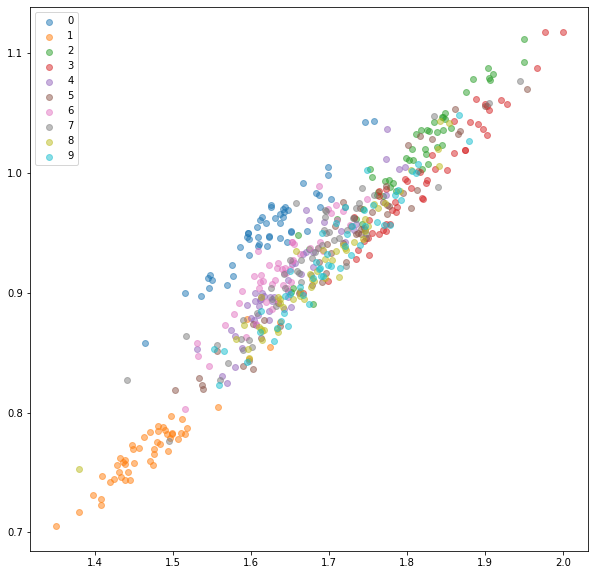

In [ ]:
plot_embeddings([*enc.values()], list(range(10)))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

## Random Testings

In [ ]:
a = torch.rand(100,1,28,28)
b = torch.rand(100,1,28,28)
c = torch.rand(100,1,28,28)

In [ ]:
trp = get_all_tensor_triplets([a,b,c], (1,2,3))

In [ ]:
trp.shape

In [ ]:
trp[:,0,...].shape

In [ ]:
trp_loader = torch.utils.data.DataLoader(rt, batch_size=20)

In [ ]:
torch.cat([i for i in trp_loader]).shape

In [ ]:
len(trp_loader)

In [ ]:
for i in trp_loader:
    print(i.shape)

In [ ]:
rt = get_random_triplets([a,b,c], [1,2,3])

In [ ]:
rt.shape

In [ ]:
a = torch.rand(5,3,4)*10
print(a.shape)
a

In [ ]:
a = torch.rand(10,2)
p = torch.rand(10,2)
n = torch.rand(10,2)
a,p,n

(tensor([[0.7896, 0.5158],
         [0.2877, 0.5015],
         [0.2847, 0.8324],
         [0.3608, 0.9372],
         [0.3799, 0.1717],
         [0.7204, 0.1638],
         [0.1053, 0.5174],
         [0.9763, 0.1723],
         [0.2700, 0.9597],
         [0.4850, 0.7582]]), tensor([[0.5777, 0.4946],
         [0.2587, 0.6608],
         [0.0787, 0.1402],
         [0.0453, 0.0809],
         [0.0551, 0.8875],
         [0.7819, 0.1165],
         [0.8714, 0.5869],
         [0.2256, 0.8397],
         [0.2104, 0.6884],
         [0.4457, 0.6710]]), tensor([[0.4039, 0.4526],
         [0.4207, 0.9289],
         [0.1743, 0.2661],
         [0.2000, 0.2397],
         [0.8647, 0.6910],
         [0.4609, 0.4615],
         [0.5447, 0.4576],
         [0.7223, 0.7270],
         [0.9221, 0.7951],
         [0.7925, 0.8124]]))

In [ ]:
(a<0.3).sum()

tensor(7)

In [ ]:
t = get_triplets([a,p,n], [0,1,2])
len(t)
# type(t[2699])
# len(t[2699][0])
# type(t[2699][0])
for _ in t: print(_, end="\n\n")

In [ ]:
tt = get_tensor_triplets([a,p,n], [0,1,2])

In [ ]:
type(tt)
tt.shape
# tt[:,0].shape
tt[:,0] #.shape

In [ ]:
exp = torch.rand(2700,1,28,28)
m = Model()

In [ ]:
t = m(exp)
t.shape

In [ ]:
t = m.convnet2(t)
t.shape

In [ ]:
t = m.convnet3(t)
t.shape

In [ ]:
t1 = t.reshape(-1, 4096)
t1.shape

In [ ]:
t1 = m.FCs(t1)
t1.shape

In [ ]:
t1 = m.out(t1)
t1.shape

In [ ]:
t.shape